In [1]:
import os
import math
import scipy
import numpy as np
from numpy import unique
from numpy import where
import pandas as pd
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
from scipy import interpolate
from scipy.interpolate import Rbf
import seawater as sw
from seawater.library import T90conv
import warnings
warnings.filterwarnings("ignore")
import h5py
import tensorflow as tf
import tensorflow.keras as keras
from numpy import save
from numpy import load
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras import regularizers  # 正则化
from tensorflow.keras.layers import Input,Dense,Dropout,Activation
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import json
from copy import deepcopy
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [2]:
with h5py.File("数据/YINDU_ALL_data.hdf5", 'r') as f:  #‘r’是读取，‘w’是写入
    print(f.keys())
    SSS_all = f.get("SSS_all")[:]
    SST_all = f.get("SST_all")[:]
    PRE_all = f.get("PRE_all")[:]
    SSHA_all = f.get("SSHA_all")[:]
    BLT_all = f.get("BLT_all")[:]
    lat = f.get("lat")[:]
    lon = f.get("lon")[:]

<KeysViewHDF5 ['BLT_all', 'PRE_all', 'SSHA_all', 'SSS_all', 'SST_all', 'lat', 'lon']>


In [3]:
print(lat.shape)
print(lon.shape)
print(SSS_all.shape)
print(SST_all.shape)
print(PRE_all.shape)
print(SSHA_all.shape)
print(BLT_all.shape)

(60,)
(90,)
(96, 60, 90)
(96, 60, 90)
(96, 60, 90)
(96, 60, 90)
(96, 60, 90)


In [ ]:
BLT = pd.DataFrame(np.nanmean(BLT,0))
BLT = BLT.fillna(999)
BLT = np.array(BLT)
BLT = np.where(BLT < 0, np.full_like(BLT,0), BLT)
BLT = np.where(BLT > 900, np.full_like(BLT,None), BLT)

In [4]:
S_x = np.array(SSS_all[:-12,:,:])
T_x = np.array(SST_all[:-12,:,:])
HA_x = np.array(SSHA_all[:-12,:,:])
P_x = np.array(PRE_all[:-12,:,:])
BLT_x = np.array(BLT_all[:-12,:,:])

S_c = np.array(SSS_all[-12:,:,:])
T_c = np.array(SST_all[-12:,:,:])
HA_c = np.array(SSHA_all[-12:,:,:])
P_c = np.array(PRE_all[-12:,:,:])
BLT_c = np.array(BLT_all[-12:,:,:])

In [5]:
xr_SST = xr.open_dataset('数据/NOAA-SST.nc')  #'SST'  00-20
xr_SST_month = xr_SST['SST'][:-1,:,:].resample(TIME="1MS").mean()
SST = xr_SST_month[:-12,:,:]

In [6]:
#经纬度坐标
LON = SST.LON31_120.values
LAT = SST.LAT61_120.values

a = []
for i in range(60):
    a.append(LON)
aa = np.array(a)

b = []
for i in range(90):
    b.append(LAT)
bb = np.array(b).T

In [7]:
S_x_df = pd.DataFrame(S_x.reshape(84,5400)).T
T_x_df = pd.DataFrame(T_x.reshape(84,5400)).T
HA_x_df = pd.DataFrame(HA_x.reshape(84,5400)).T
P_x_df = pd.DataFrame(P_x.reshape(84,5400)).T
BLT_x_df = pd.DataFrame(BLT_x.reshape(84,5400)).T

S_c_df = pd.DataFrame(S_c.reshape(12,5400)).T
T_c_df = pd.DataFrame(T_c.reshape(12,5400)).T
HA_c_df = pd.DataFrame(HA_c.reshape(12,5400)).T
P_c_df = pd.DataFrame(P_c.reshape(12,5400)).T
BLT_c_df = pd.DataFrame(BLT_c.reshape(12,5400)).T

LON_df = pd.DataFrame(aa.reshape(1,5400)).T
LAT_df = pd.DataFrame(bb.reshape(1,5400)).T

In [8]:
train_df = pd.DataFrame()
for i in range(7):
    month = pd.concat([S_x_df.iloc[:, i * 12], T_x_df.iloc[:, i * 12], HA_x_df.iloc[:, i * 12], P_x_df.iloc[:, i * 12],
                       LON_df, LAT_df, BLT_x_df.iloc[:, i * 12]], axis = 1)
    month.columns = ['SSS','SST','SSHA','PRE','LON','LAT','BLT']
    train_df = pd.concat([train_df, month],axis = 0).dropna()

test_df = pd.concat([S_c_df.iloc[:,0], T_c_df.iloc[:,0], HA_c_df.iloc[:,0], P_c_df.iloc[:,0],
                     LON_df, LAT_df, BLT_c_df.iloc[:,0]], axis = 1).dropna()
test_df.columns = ['SSS','SST','SSHA','PRE','LON','LAT','BLT']


x_train_df = train_df[['SSS','SST','SSHA','PRE','LON','LAT']]
y_train_df = train_df[['BLT']]
x_test_df = test_df[['SSS','SST','SSHA','PRE','LON','LAT']]
y_test_df = test_df[['BLT']]

In [9]:
MARK = x_test_df.index
num = list(range(0,5400,1))
index = [str(x) for x in num]
M = pd.DataFrame([index]).T

MARKarray = np.array(MARK)
MARKt = []
for i in range(7):
    MARKt.append(MARKarray)
MARKtest = np.array(MARKt)
MARKtest = MARKtest.reshape(20734)

In [10]:
x_train_df

,SSS,SST,SSHA,PRE,LON,LAT
2,35.379654,26.346003,0.045350,0.889355,32.5,-29.5
3,35.491821,26.276001,0.068275,0.596452,33.5,-29.5
4,35.522892,26.114002,-0.061375,0.343226,34.5,-29.5
5,35.505867,25.862000,-0.100000,0.274516,35.5,-29.5
6,35.528584,25.567999,0.104975,0.236774,36.5,-29.5
...,...,...,...,...,...,...
4891,36.618168,23.865002,0.135225,0.000000,61.5,24.5
4892,36.620899,24.022501,0.091725,0.000000,62.5,24.5
4893,36.682346,23.975000,0.055450,0.000000,63.5,24.5
4894,36.589848,23.757500,0.113450,0.000000,64.5,24.5


ann

In [11]:
hidden_1 = 64
hidden_2 = 128
p = 0.3
model = Sequential()
model.add(Dense(units = hidden_1,
                activation='relu',
                input_shape=(x_train_df.shape[1],)))
model.add(Dropout(p))
model.add(Dense(units = hidden_2,
                activation='relu',))
model.add(Dense(units = 1,
                activation='linear'))
model.compile(loss='mse',                           # 损失均方误差
              optimizer='adam',                     # 优化器
             )
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                448       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 8,897
Trainable params: 8,897
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
a = np.zeros((1,60,90))
b = np.zeros((1,60,90))
RMSE = []
R2 = []
for j in range(12):
    print('月份:'+str(j+1))
    train_df = pd.DataFrame()
    for i in range(7):
        month = pd.concat([S_x_df.iloc[:, i * 12 + j], T_x_df.iloc[:, i * 12 + j], HA_x_df.iloc[:, i * 12 + j], P_x_df.iloc[:, i * 12 + j],
                           LON_df, LAT_df, BLT_x_df.iloc[:, i * 12 + j]], axis = 1)
        month.columns = ['SSS','SST','SSHA','PRE','LON','LAT','BLT']
        train_df = pd.concat([train_df, month],axis = 0).dropna()

    test_df = pd.concat([S_c_df.iloc[:,j], T_c_df.iloc[:,j], HA_c_df.iloc[:,j], P_c_df.iloc[:,j],
                         LON_df, LAT_df, BLT_c_df.iloc[:,j]], axis = 1).dropna()
    test_df.columns = ['SSS','SST','SSHA','PRE','LON','LAT','BLT']


    x_train_df = train_df[['SSS','SST','SSHA','PRE','LON','LAT']]
    y_train_df = train_df[['BLT']]
    x_test_df = test_df[['SSS','SST','SSHA','PRE','LON','LAT']]
    y_test_df = test_df[['BLT']]

    # 训练集标准化  
    scaler.fit(x_train_df)
    x_train = scaler.transform(x_train_df)
    scaler.fit(y_train_df)
    y_train = scaler.transform(y_train_df)
    # 测试集标准化  
    scaler.fit(x_test_df)
    x_test = scaler.transform(x_test_df)
    scaler.fit(y_test_df)
    y_test = scaler.transform(y_test_df)
    
    #划分80/20
    np.random.shuffle(train)
    x_train = data[:len(train)*0.8]
    x_val = data[len(train)*0.8:]
    y_train = data[:len(train)*0.8]
    y_val = data[len(train)*0.8:]
    
    hidden_1 = 64
    hidden_2 = 128
    p = 0.3
    model = Sequential()
    model.add(Dense(units = hidden_1,
                    activation='relu',
                    input_shape=(x_train_df.shape[1],)))
    model.add(Dropout(p))
    model.add(Dense(units = hidden_2,
                    activation='relu',))
    model.add(Dense(units = 1,
                    activation='linear'))
    model.compile(loss='mse',                           # 损失均方误差
                  optimizer='adam',                     # 优化器
                 )
    
    model.fit(x_train, y_train, epochs=20,batch_size=500,verbose=0,validation_data = (x_val,y_val))
    y_new = model.predict(x_test)
    # 反归一化还原原始量纲
    scaler.fit(y_test_df)
    y_new = scaler.inverse_transform(y_new)

    y_test = pd.DataFrame(y_test_df.values)
    y_new = pd.DataFrame(y_new)
    y = pd.concat([y_test,y_new], axis=1)
    print(str(j+1)+'月 RMSE : %.3f' % (mean_squared_error(y.iloc[:,0].values,y.iloc[:,1].values) ** 0.5))
    print(str(j+1)+'月 R^2 : %.3f' % (r2_score(y.iloc[:,0].values,y.iloc[:,1].values)))

    y_new.index = y_test_df.index
    Y = pd.concat([y_test_df,y_new,M],axis=1)
    BLT = np.array(Y.iloc[:,0].T).reshape(1,60,90)
    BLTpred =  np.array(Y.iloc[:,1].T).reshape(1,60,90)
    
    a = np.concatenate((a,BLT),0)
    b = np.concatenate((b,BLTpred),0)
    RMSE.append(mean_squared_error(y.iloc[:,0].values,y.iloc[:,1].values) ** 0.5)
    R2.append(r2_score(y.iloc[:,0].values,y.iloc[:,1].values))

月份:1
648/648 [==============================] - 1s 2ms/step - loss: 0.3269
1月 RMSE : 4.631
1月 R^2 : 0.816
月份:2
648/648 [==============================] - 1s 2ms/step - loss: 0.2892
2月 RMSE : 5.388
2月 R^2 : 0.769
月份:3
648/648 [==============================] - 1s 2ms/step - loss: 0.4676
3月 RMSE : 3.861
3月 R^2 : 0.456
月份:4
648/648 [==============================] - 1s 2ms/step - loss: 0.6280
4月 RMSE : 3.102
4月 R^2 : 0.274
月份:5
648/648 [==============================] - 1s 2ms/step - loss: 0.6620
5月 RMSE : 3.385
5月 R^2 : 0.320
月份:6
648/648 [==============================] - 1s 2ms/step - loss: 0.5963
6月 RMSE : 3.856
6月 R^2 : 0.350
月份:7
648/648 [==============================] - 1s 2ms/step - loss: 0.5333
7月 RMSE : 4.838
7月 R^2 : 0.580
月份:8
648/648 [==============================] - 1s 2ms/step - loss: 0.5064
8月 RMSE : 6.346
8月 R^2 : 0.584
月份:9
648/648 [==============================] - 1s 2ms/step - loss: 0.5653
9月 RMSE : 5.801
9月 R^2 : 0.296
月份:10
648/648 [==============================]

In [ ]:
bar = [[0,15,30,45,60],[0,15,30,45,60],[0,10,20,30,40],[0,10,20,30,40],[0,10,20,30,40],[0,15,30,45,60],[0,15,30,45,60],[0,25,50,75,100],[0,20,40,60,80],[0,15,30,45,60],[0,15,30,45,60],[0,15,30,45,60]]
for j in range(12):
    lat = np.arange(-30,30)
    lon = np.arange(30,120)
    proj = ccrs.PlateCarree()
    fig = plt.figure(figsize=(14, 7))

    font2 = {'family' : 'Times New Roman',
    'weight' : 'bold',
    'size'   : 30,
    }

    
    ax1 =  fig.add_subplot(1, 2, 1, projection=proj)
    real = ax1.contourf(lon,lat,a[j+1,:,:],levels=50,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('jet'))
    ax1.coastlines("10m")
    plt.tick_params(labelsize=14)
    ax1.set_xticks([30,60,90,120], crs=ccrs.PlateCarree())
    ax1.set_yticks([-30,-15,0,15,30], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)
    plt.title('the '+ str(j+1) +' month Argo-BLT',font2,fontsize=20,y=1.05)
    cbar = plt.colorbar(real,extend='both',orientation='horizontal')
    cbar.ax.tick_params(labelsize=17)
    cbar.set_ticks(bar[j])
    plt.grid(linestyle='-.')

    ax2 =  fig.add_subplot(1, 2, 2, projection=proj)
    pre = ax2.contourf(lon,lat,b[j+1,:,:],levels=50,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('jet'))
    ax2.coastlines("10m")
    plt.tick_params(labelsize=14)
    ax2.set_xticks([30,60,90,120], crs=ccrs.PlateCarree())
    ax2.set_yticks([-30,-15,0,15,30], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
    plt.title('the '+ str(j+1) +' month ANN-BLT',font2, fontsize=20,y=1.05)
    cbar = plt.colorbar(real,extend='both',orientation='horizontal')
    cbar.ax.tick_params(labelsize=17)
    cbar.set_ticks(bar[j])
    plt.grid(linestyle='-.')
    plt.text(92,25,'MSE='+str(round(RMSE[j],3)),fontsize='15')
    plt.text(92,20,'r$^2$ = '+str(round(R2[j],3)),fontsize='15')
    plt.show()

月平均 RMSE : 2.006
月平均 R^2 : 0.821


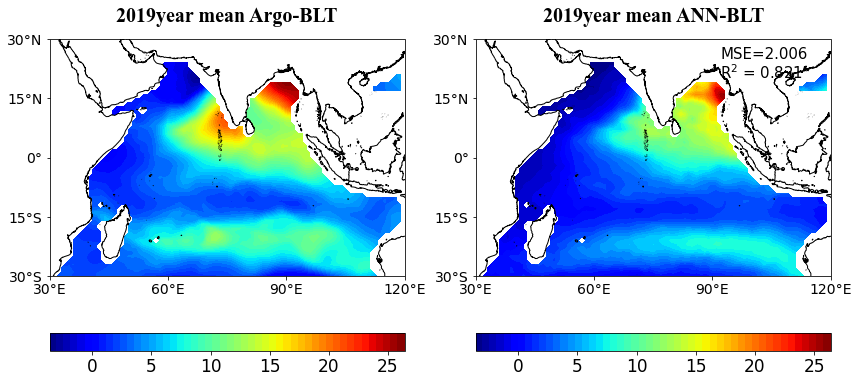

In [14]:
aa = np.nanmean(a[1:,:,:],axis=0).reshape(5400)
bb = np.nanmean(b[1:,:,:],axis=0).reshape(5400)
aa = pd.DataFrame(aa)
bb = pd.DataFrame(bb)
y = pd.concat([aa,bb], axis=1).dropna()
print('月平均 RMSE : %.3f' % (mean_squared_error(y.iloc[:,0].values,y.iloc[:,1].values) ** 0.5))
print('月平均 R^2 : %.3f' % (r2_score(y.iloc[:,0].values,y.iloc[:,1].values)))

lat = np.arange(-30,30)
lon = np.arange(30,120)
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(14, 7))

font2 = {'family' : 'Times New Roman',
'weight' : 'bold',
'size'   : 30,
}

ax1 =  fig.add_subplot(1, 2, 1, projection=proj)
real = ax1.contourf(lon,lat,np.nanmean(a[1:,:,:],axis=0),levels=50,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('jet'))
ax1.coastlines("10m")
plt.tick_params(labelsize=14)
ax1.set_xticks([30,60,90,120], crs=ccrs.PlateCarree())
ax1.set_yticks([-30,-15,0,15,30], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
plt.title('2019year mean Argo-BLT',font2,fontsize=20,y=1.05)
cbar = plt.colorbar(real,extend='both',orientation='horizontal')
cbar.ax.tick_params(labelsize=17)
cbar.set_ticks([0,5,10,15,20,25])
plt.grid(linestyle='-.')

ax2 =  fig.add_subplot(1, 2, 2, projection=proj)
pre = ax2.contourf(lon,lat,np.nanmean(b[1:,:,:],axis=0),levels=50,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('jet'))
ax2.coastlines("10m")
plt.tick_params(labelsize=14)
ax2.set_xticks([30,60,90,120], crs=ccrs.PlateCarree())
ax2.set_yticks([-30,-15,0,15,30], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
plt.title('2019year mean ANN-BLT',font2, fontsize=20,y=1.05)
cbar = plt.colorbar(real,extend='both',orientation='horizontal')
cbar.ax.tick_params(labelsize=17)
cbar.set_ticks([0,5,10,15,20,25])
plt.grid(linestyle='-.')
plt.text(92,25,'MSE='+str(round(mean_squared_error(y.iloc[:,0].values,y.iloc[:,1].values) ** 0.5,3)),fontsize='15')
plt.text(92,20,'R$^2$ = '+str(round(r2_score(y.iloc[:,0].values,y.iloc[:,1].values),3)),fontsize='15')
plt.show()

In [ ]:
BLT = pd.DataFrame(np.nanmean(BLT,0))
BLT = BLT.fillna(999)
BLT = np.array(BLT)
BLT = np.where(BLT < 0, np.full_like(BLT,0), BLT)
BLT = np.where(BLT > 900, np.full_like(BLT,None), BLT)

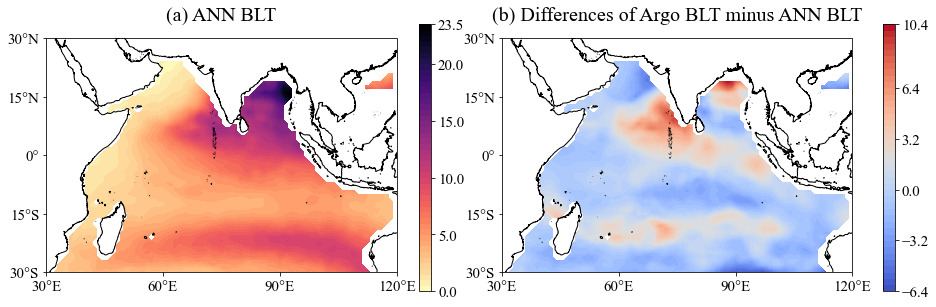

In [16]:
lat = np.arange(-30,30)
lon = np.arange(30,120)
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(14, 7))

font = {'family':'Times New Roman'}

ANN_P = np.where(np.nanmean(b[1:,:,:],axis=0) < 0, np.full_like(np.nanmean(b[1:,:,:],axis=0),0), np.nanmean(b[1:,:,:],axis=0))
ax2 =  fig.add_subplot(1, 2, 1, projection=proj)
pre = ax2.contourf(lon,lat,ANN_P,levels=50,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('magma_r'))
ax2.coastlines("10m")
plt.tick_params(labelsize=15)
ax2.set_xticks([30,60,90,120], crs=ccrs.PlateCarree())
ax2.set_yticks([-30,-15,0,15,30], crs=ccrs.PlateCarree())

lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
for tick in ax2.get_xticklabels():
    tick.set_fontname("Times New Roman") 
for tick in ax2.get_yticklabels():
    tick.set_fontname("Times New Roman") 
plt.title('(a) ANN BLT',font, fontsize=20,y=1.05)
plt.grid(linestyle='-.')
cbar_ax = fig.add_axes([0.47, 0.23, 0.012, 0.53]) # 调整colorbar位置
cbar = plt.colorbar(pre, cax=cbar_ax, anchor='right')
cbar.ax.tick_params(labelsize=15)
cbar.set_ticks([0,5,10,15,20,float(f"{cbar.vmax:.2f}")])

ax2 =  fig.add_subplot(1, 2, 2, projection=proj)
dif = ax2.contourf(lon,lat,np.nanmean(a[1:,:,:],axis=0)-ANN_P,levels=50,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('coolwarm'))
ax2.coastlines("10m")
plt.tick_params(labelsize=15)
ax2.set_xticks([30,60,90,120], crs=ccrs.PlateCarree())
ax2.set_yticks([-30,-15,0,15,30], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
for tick in ax2.get_xticklabels():
    tick.set_fontname("Times New Roman") 
for tick in ax2.get_yticklabels():
    tick.set_fontname("Times New Roman") 
plt.title('(b) Differences of Argo BLT minus ANN BLT',font, fontsize=20,y=1.05)
plt.grid(linestyle='-.')

cbar_ax = fig.add_axes([0.93, 0.23, 0.012, 0.53]) # 调整colorbar位置
cbar = plt.colorbar(dif, cax=cbar_ax, anchor='right')
cbar.ax.tick_params(labelsize=15)
cbar.set_ticks([float(f"{cbar.vmin:.2f}"),-3.2,0,3.2,6.4,float(f"{cbar.vmax:.2f}")])
plt.rcParams['font.family'] = 'Times New Roman'

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3)

plt.savefig('图对比ANN.png')
plt.show()

In [15]:
RMSE_ANN = RMSE
R2_ANN = R2

In [16]:
ANN_JIEGUO = np.nanmean(b[1:,:,:],axis=0)

多元线性回归

In [17]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression(fit_intercept=False)

In [18]:
a = np.zeros((1,60,90))
b = np.zeros((1,60,90))
RMSE = []
R2 = []
for j in range(12):
    print('月份:'+str(j+1))
    train_df = pd.DataFrame()
    for i in range(7):
        month = pd.concat([S_x_df.iloc[:, i * 12 + j], T_x_df.iloc[:, i * 12 + j], HA_x_df.iloc[:, i * 12 + j], P_x_df.iloc[:, i * 12 + j],
                           LON_df, LAT_df, BLT_x_df.iloc[:, i * 12 + j]], axis = 1)
        month.columns = ['SSS','SST','SSHA','PRE','LON','LAT','BLT']
        train_df = pd.concat([train_df, month],axis = 0).dropna()

    test_df = pd.concat([S_c_df.iloc[:,j], T_c_df.iloc[:,j], HA_c_df.iloc[:,j], P_c_df.iloc[:,j],
                         LON_df, LAT_df, BLT_c_df.iloc[:,j]], axis = 1).dropna()
    test_df.columns = ['SSS','SST','SSHA','PRE','LON','LAT','BLT']


    x_train_df = train_df[['SSS','SST','SSHA','PRE','LON','LAT']]
    y_train_df = train_df[['BLT']]
    x_test_df = test_df[['SSS','SST','SSHA','PRE','LON','LAT']]
    y_test_df = test_df[['BLT']]

    # 训练集标准化  
    scaler.fit(x_train_df)
    x_train = scaler.transform(x_train_df)
    scaler.fit(y_train_df)
    y_train = scaler.transform(y_train_df)
    # 测试集标准化  
    scaler.fit(x_test_df)
    x_test = scaler.transform(x_test_df)
    scaler.fit(y_test_df)
    y_test = scaler.transform(y_test_df)
    
    #划分80/20
    np.random.shuffle(train)
    x_train = data[:len(train)*0.8]
    x_val = data[len(train)*0.8:]
    y_train = data[:len(train)*0.8]
    y_val = data[len(train)*0.8:]
    
    clf.fit(x_train, y_train, epochs=20,batch_size=500,verbose=0,validation_data = (x_val,y_val))
    y_new = clf.predict(x_test)
    # 反归一化还原原始量纲
    scaler.fit(y_test_df)
    y_new = scaler.inverse_transform(y_new)

    y_test = pd.DataFrame(y_test_df.values)
    y_new = pd.DataFrame(y_new)
    y = pd.concat([y_test,y_new], axis=1)
    print(str(j+1)+'月 RMSE : %.3f' % (mean_squared_error(y.iloc[:,0].values,y.iloc[:,1].values) ** 0.5))
    print(str(j+1)+'月 R^2 : %.3f' % (r2_score(y.iloc[:,0].values,y.iloc[:,1].values)))

    y_new.index = y_test_df.index
    Y = pd.concat([y_test_df,y_new,M],axis=1)
    BLT = np.array(Y.iloc[:,0].T).reshape(1,60,90)
    BLTpred =  np.array(Y.iloc[:,1].T).reshape(1,60,90)
    
    a = np.concatenate((a,BLT),0)
    b = np.concatenate((b,BLTpred),0)
    RMSE.append(mean_squared_error(y.iloc[:,0].values,y.iloc[:,1].values) ** 0.5)
    R2.append(r2_score(y.iloc[:,0].values,y.iloc[:,1].values))

月份:1
1月 RMSE : 7.187
1月 R^2 : 0.556
月份:2
2月 RMSE : 7.775
2月 R^2 : 0.519
月份:3
3月 RMSE : 4.565
3月 R^2 : 0.240
月份:4
4月 RMSE : 3.415
4月 R^2 : 0.120
月份:5
5月 RMSE : 3.834
5月 R^2 : 0.128
月份:6
6月 RMSE : 4.380
6月 R^2 : 0.161
月份:7
7月 RMSE : 6.241
7月 R^2 : 0.301
月份:8
8月 RMSE : 8.613
8月 R^2 : 0.234
月份:9
9月 RMSE : 6.735
9月 R^2 : 0.051
月份:10
10月 RMSE : 4.757
10月 R^2 : 0.456
月份:11
11月 RMSE : 5.350
11月 R^2 : 0.448
月份:12
12月 RMSE : 5.874
12月 R^2 : 0.597


In [ ]:
bar = [[0,15,30,45,60],[0,15,30,45,60],[0,10,20,30,40],[0,10,20,30,40],[0,10,20,30,40],[0,15,30,45,60],[0,15,30,45,60],[0,25,50,75,100],[0,20,40,60,80],[0,15,30,45,60],[0,15,30,45,60],[0,15,30,45,60]]
for j in range(12):
    lat = np.arange(-30,30)
    lon = np.arange(30,120)
    proj = ccrs.PlateCarree()
    fig = plt.figure(figsize=(14, 7))

    font2 = {'family' : 'Times New Roman',
    'weight' : 'bold',
    'size'   : 30,
    }

    
    ax1 =  fig.add_subplot(1, 2, 1, projection=proj)
    real = ax1.contourf(lon,lat,a[j+1,:,:],levels=50,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('jet'))
    ax1.coastlines("10m")
    plt.tick_params(labelsize=14)
    ax1.set_xticks([30,60,90,120], crs=ccrs.PlateCarree())
    ax1.set_yticks([-30,-15,0,15,30], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)
    plt.title('the '+ str(j+1) +' month Argo-BLT',font2,fontsize=20,y=1.05)
    cbar = plt.colorbar(real,extend='both',orientation='horizontal')
    cbar.ax.tick_params(labelsize=17)
    cbar.set_ticks(bar[j])
    plt.grid(linestyle='-.')

    ax2 =  fig.add_subplot(1, 2, 2, projection=proj)
    pre = ax2.contourf(lon,lat,b[j+1,:,:],levels=50,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('jet'))
    ax2.coastlines("10m")
    plt.tick_params(labelsize=14)
    ax2.set_xticks([30,60,90,120], crs=ccrs.PlateCarree())
    ax2.set_yticks([-30,-15,0,15,30], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
    plt.title('the '+ str(j+1) +' month ANN-BLT',font2, fontsize=20,y=1.05)
    cbar = plt.colorbar(real,extend='both',orientation='horizontal')
    cbar.ax.tick_params(labelsize=17)
    cbar.set_ticks(bar[j])
    plt.grid(linestyle='-.')
    plt.text(92,25,'MSE='+str(round(RMSE[j],3)),fontsize='15')
    plt.text(92,20,'r$^2$ = '+str(round(R2[j],3)),fontsize='15')
    plt.show()

In [45]:
print('月平均 RMSE : %.3f' % (mean_squared_error(y.iloc[:,0].values,y.iloc[:,1].values) ** 0.5))
print('月平均 R^2 : %.3f' % (r2_score(y.iloc[:,0].values,y.iloc[:,1].values)))

月平均 RMSE : 5.874
月平均 R^2 : 0.597


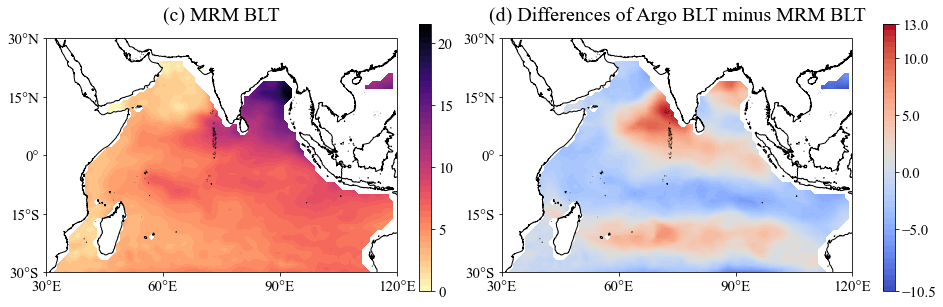

In [19]:
lat = np.arange(-30,30)
lon = np.arange(30,120)
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(14, 7))

font = {'family':'Times New Roman'}

MRM_P = np.where(np.nanmean(b[1:,:,:],axis=0) < 0, np.full_like(np.nanmean(b[1:,:,:],axis=0),0), np.nanmean(b[1:,:,:],axis=0))
ax2 =  fig.add_subplot(1, 2, 1, projection=proj)
pre = ax2.contourf(lon,lat,MRM_P,levels=50,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('magma_r'))
ax2.coastlines("10m")
plt.tick_params(labelsize=15)
ax2.set_xticks([30,60,90,120], crs=ccrs.PlateCarree())
ax2.set_yticks([-30,-15,0,15,30], crs=ccrs.PlateCarree())

lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
for tick in ax2.get_xticklabels():
    tick.set_fontname("Times New Roman") 
for tick in ax2.get_yticklabels():
    tick.set_fontname("Times New Roman") 
plt.title('(c) MRM BLT',font, fontsize=20,y=1.05)
plt.grid(linestyle='-.')
cbar_ax = fig.add_axes([0.47, 0.23, 0.012, 0.53]) # 调整colorbar位置
cbar = plt.colorbar(pre, cax=cbar_ax, anchor='right')
cbar.ax.tick_params(labelsize=15)
cbar.set_ticks([0,5,10,15,20])

ax2 =  fig.add_subplot(1, 2, 2, projection=proj)
dif = ax2.contourf(lon,lat,np.nanmean(a[1:,:,:],axis=0)-MRM_P,levels=50,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('coolwarm'))
ax2.coastlines("10m")
plt.tick_params(labelsize=15)
ax2.set_xticks([30,60,90,120], crs=ccrs.PlateCarree())
ax2.set_yticks([-30,-15,0,15,30], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
for tick in ax2.get_xticklabels():
    tick.set_fontname("Times New Roman") 
for tick in ax2.get_yticklabels():
    tick.set_fontname("Times New Roman") 
plt.title('(d) Differences of Argo BLT minus MRM BLT',font, fontsize=20,y=1.05)
plt.grid(linestyle='-.')
cbar_ax = fig.add_axes([0.93, 0.23, 0.012, 0.53]) # 调整colorbar位置
cbar = plt.colorbar(dif, cax=cbar_ax, anchor='right')
cbar.ax.tick_params(labelsize=15)
cbar.set_ticks([float(f"{cbar.vmin:.2f}"),-5,0,5,10,float(f"{cbar.vmax:.2f}")])
plt.rcParams['font.family'] = 'Times New Roman'

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3)

plt.savefig('图对比MRM.png')
plt.show()

In [20]:
#读取npy文件
from numpy import load
BLT_CMIP6 = load('CMIP6_data.npy')

#读取npy文件
from numpy import load
BLT_Argo = load('data.npy')

In [21]:
BLT_Argo = pd.DataFrame(np.nanmean(BLT_Argo,0))
BLT_Argo = BLT_Argo.fillna(999)
BLT_Argo = np.array(BLT_Argo)
BLT_Argo = np.where(BLT_Argo < 0, np.full_like(BLT_Argo,0), BLT_Argo)
BLT_Argo = np.where(BLT_Argo > 900, np.full_like(BLT_Argo,None), BLT_Argo)

BLT_CMIP6 = pd.DataFrame(np.nanmean(BLT_CMIP6,0))
BLT_CMIP6 = BLT_CMIP6.fillna(999)
BLT_CMIP6 = np.array(BLT_CMIP6)
BLT_CMIP6 = np.where(BLT_CMIP6 < 0, np.full_like(BLT_CMIP6,0), BLT_CMIP6)
BLT_CMIP6 = np.where(BLT_CMIP6 > 900, np.full_like(BLT_CMIP6,None), BLT_CMIP6)

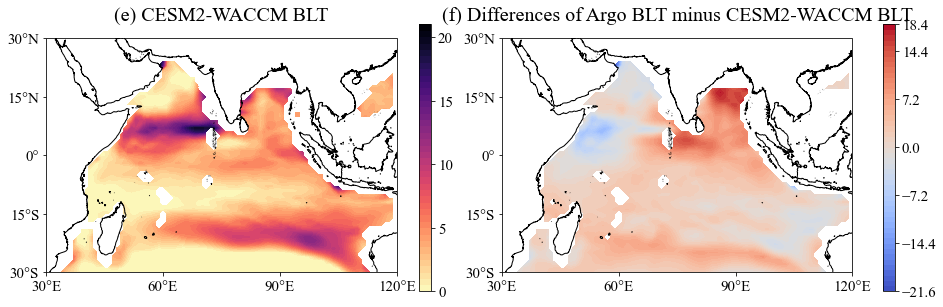

In [25]:
lat = np.arange(-30,30)
lon = np.arange(30,120)
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(14, 7))

font = {'family':'Times New Roman'}

ax2 =  fig.add_subplot(1, 2, 1, projection=proj)
pre = ax2.contourf(lon,lat,BLT_CMIP6,levels=50,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('magma_r'))
ax2.coastlines("10m")
plt.tick_params(labelsize=15)
ax2.set_xticks([30,60,90,120], crs=ccrs.PlateCarree())
ax2.set_yticks([-30,-15,0,15,30], crs=ccrs.PlateCarree())

lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
for tick in ax2.get_xticklabels():
    tick.set_fontname("Times New Roman") 
for tick in ax2.get_yticklabels():
    tick.set_fontname("Times New Roman") 
plt.title('(e) CESM2-WACCM BLT',font, fontsize=20,y=1.05)
plt.grid(linestyle='-.')
cbar_ax = fig.add_axes([0.47, 0.23, 0.012, 0.53]) # 调整colorbar位置
cbar = plt.colorbar(pre, cax=cbar_ax, anchor='right')
cbar.ax.tick_params(labelsize=15)
cbar.set_ticks([0,5,10,15,20])

ax2 =  fig.add_subplot(1, 2, 2, projection=proj)
dif = ax2.contourf(lon,lat,np.nanmean(a[1:,:,:],axis=0)-BLT_CMIP6,levels=50,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('coolwarm'))
ax2.coastlines("10m")
plt.tick_params(labelsize=15)
ax2.set_xticks([30,60,90,120], crs=ccrs.PlateCarree())
ax2.set_yticks([-30,-15,0,15,30], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
for tick in ax2.get_xticklabels():
    tick.set_fontname("Times New Roman") 
for tick in ax2.get_yticklabels():
    tick.set_fontname("Times New Roman") 
plt.title('(f) Differences of Argo BLT minus CESM2-WACCM BLT',font, fontsize=20,y=1.05)
plt.grid(linestyle='-.')
cbar_ax = fig.add_axes([0.93, 0.23, 0.012, 0.53]) # 调整colorbar位置
cbar = plt.colorbar(dif, cax=cbar_ax, anchor='right')
cbar.ax.tick_params(labelsize=15)
cbar.set_ticks([float(f"{cbar.vmin:.2f}"),float(f"{cbar.vmin:.2f}")/3,2*float(f"{cbar.vmin:.2f}")/3,0,-float(f"{cbar.vmin:.2f}")/3,-2*float(f"{cbar.vmin:.2f}")/3,float(f"{cbar.vmax:.2f}")])
plt.rcParams['font.family'] = 'Times New Roman'

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3)

plt.savefig('图对比CMIP6.png')
plt.show()

ANN总体模型

In [21]:
hidden_1 = 64
hidden_2 = 128
p = 0.3
model = Sequential()
model.add(Dense(units = hidden_1,
                activation='relu',
                input_shape=(x_train_df.shape[1],)))
model.add(Dropout(p))
model.add(Dense(units = hidden_2,
                activation='relu',
                bias_regularizer=keras.regularizers.l1_l2(0.01)))
model.add(Dense(units = 1,
                activation='linear'))
model.compile(loss='mse',                           # 损失均方误差
              optimizer='adam',                     # 优化器
             )
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 64)                448       
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 129       
Total params: 8,897
Trainable params: 8,897
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
# 保存模型
model.save('model_MLP.h5')  # 生成模型文件 'my_model.h5'
# 加载模型
model = load_model('model_MLP.h5')

In [ ]:
a = np.zeros((1,60,90))
b = np.zeros((1,60,90))
RMSE = []
R2 = []

train_df = pd.DataFrame()
for i in range(84):
    month = pd.concat([S_x_df.iloc[:,i], T_x_df.iloc[:,i], HA_x_df.iloc[:,i], P_x_df.iloc[:,i],LON_df, LAT_df, BLT_x_df.iloc[:,i]], axis = 1)
    month.columns = ['SSS','SST','SSHA','PRE','LON','LAT','BLT']
    train_df = pd.concat([train_df, month],axis = 0).dropna()
    
    x_train_df = train_df[['SSS','SST','SSHA','PRE','LON','LAT']]
    y_train_df = train_df[['BLT']]
    
# 训练集标准化  
scaler.fit(x_train_df)
x_train = scaler.transform(x_train_df)
scaler.fit(y_train_df)
y_train = scaler.transform(y_train_df)
    
#划分80/20
np.random.shuffle(train)
x_train = data[:len(train)*0.8]
x_val = data[len(train)*0.8:]
y_train = data[:len(train)*0.8]
y_val = data[len(train)*0.8:]

model.fit(x_train,y_train,epochs=100,batch_size=1000,verbose=0,validation_data = (x_val,y_val))

In [24]:
for j in range(12):
    print('月份:'+str(j+1))
    test_df = pd.concat([S_c_df.iloc[:,j], T_c_df.iloc[:,j], HA_c_df.iloc[:,j], P_c_df.iloc[:,j],
                         LON_df, LAT_df, BLT_c_df.iloc[:,j]], axis = 1).dropna()
    test_df.columns = ['SSS','SST','SSHA','PRE','LON','LAT','BLT']

    x_test_df = test_df[['SSS','SST','SSHA','PRE','LON','LAT']]
    y_test_df = test_df[['BLT']]

    # 测试集标准化  
    scaler.fit(x_test_df)
    x_test = scaler.transform(x_test_df)
    scaler.fit(y_test_df)
    y_test = scaler.transform(y_test_df)

    y_new = model.predict(x_test)
    # 反归一化还原原始量纲
    scaler.fit(y_test_df)
    y_new = scaler.inverse_transform(y_new)

    y_test = pd.DataFrame(y_test_df.values)
    y_new = pd.DataFrame(y_new)
    y = pd.concat([y_test,y_new], axis=1)
    print(str(j+1)+'月 RMSE : %.3f' % (mean_squared_error(y.iloc[:,0].values,y.iloc[:,1].values) ** 0.5))
    print(str(j+1)+'月 R^2 : %.3f' % (r2_score(y.iloc[:,0].values,y.iloc[:,1].values)))

    y_new.index = y_test_df.index
    Y = pd.concat([y_test_df,y_new,M],axis=1)
    BLT = np.array(Y.iloc[:,0].T).reshape(1,60,90)
    BLTpred =  np.array(Y.iloc[:,1].T).reshape(1,60,90)

    a = np.concatenate((a,BLT),0)
    b = np.concatenate((b,BLTpred),0)
    RMSE.append(mean_squared_error(y.iloc[:,0].values,y.iloc[:,1].values) ** 0.5)
    R2.append(r2_score(y.iloc[:,0].values,y.iloc[:,1].values))

月份:1
1月 RMSE : 7.084
1月 R^2 : 0.569
月份:2
2月 RMSE : 7.170
2月 R^2 : 0.591
月份:3
3月 RMSE : 4.175
3月 R^2 : 0.364
月份:4
4月 RMSE : 3.274
4月 R^2 : 0.191
月份:5
5月 RMSE : 3.432
5月 R^2 : 0.301
月份:6
6月 RMSE : 4.178
6月 R^2 : 0.237
月份:7
7月 RMSE : 6.863
7月 R^2 : 0.155
月份:8
8月 RMSE : 9.231
8月 R^2 : 0.121
月份:9
9月 RMSE : 6.093
9月 R^2 : 0.224
月份:10
10月 RMSE : 5.375
10月 R^2 : 0.305
月份:11
11月 RMSE : 5.875
11月 R^2 : 0.335
月份:12
12月 RMSE : 6.392
12月 R^2 : 0.523


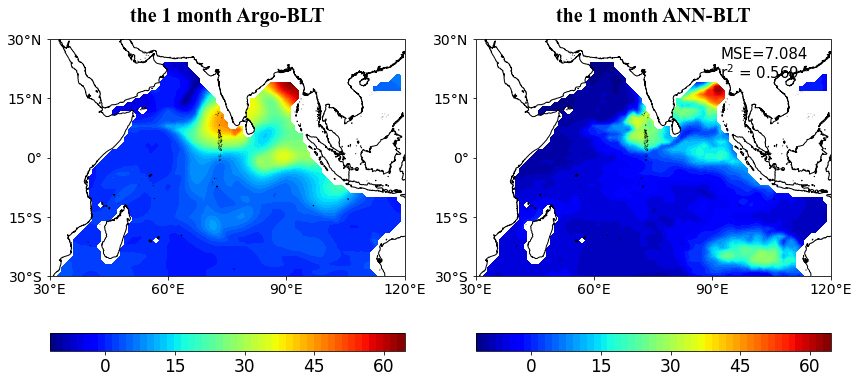

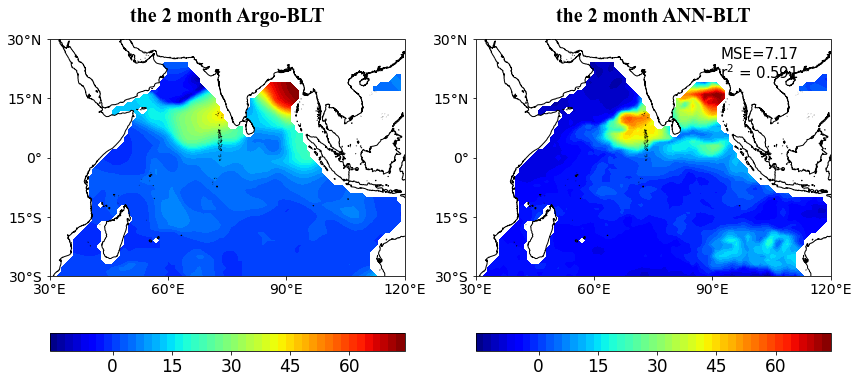

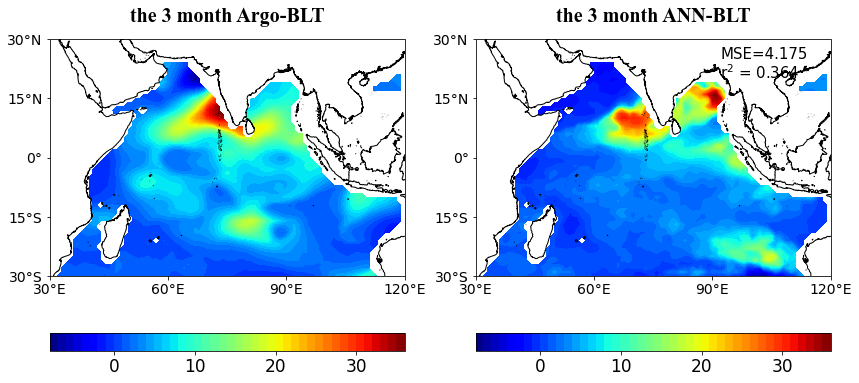

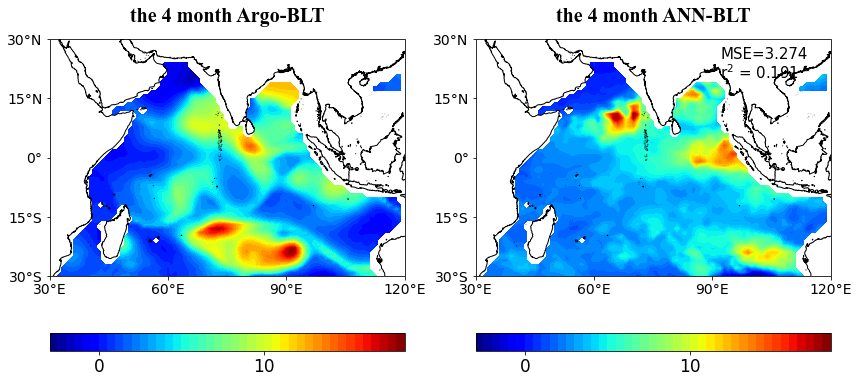

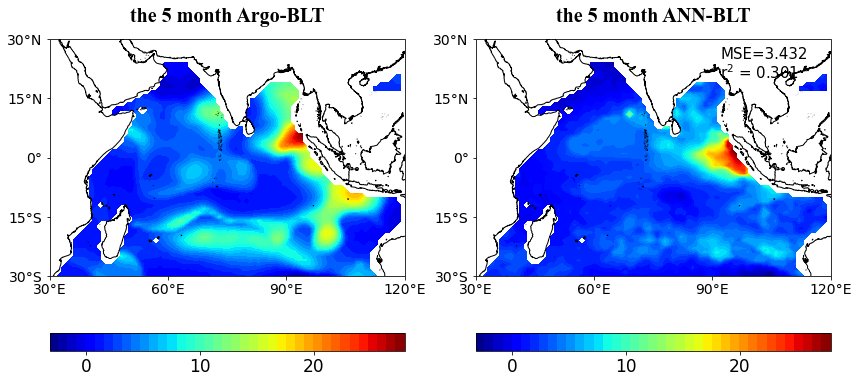

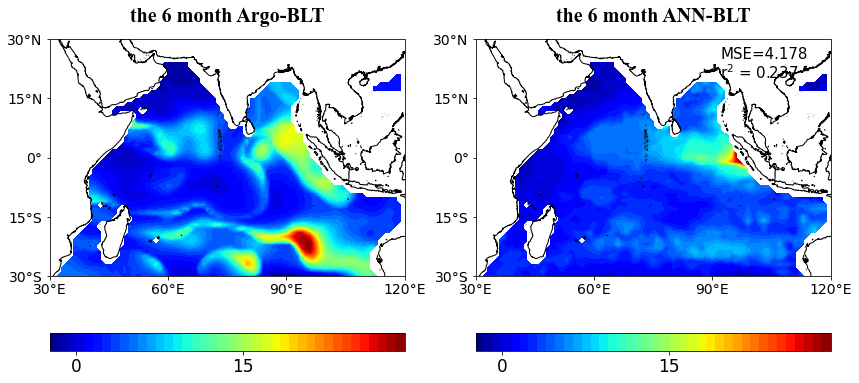

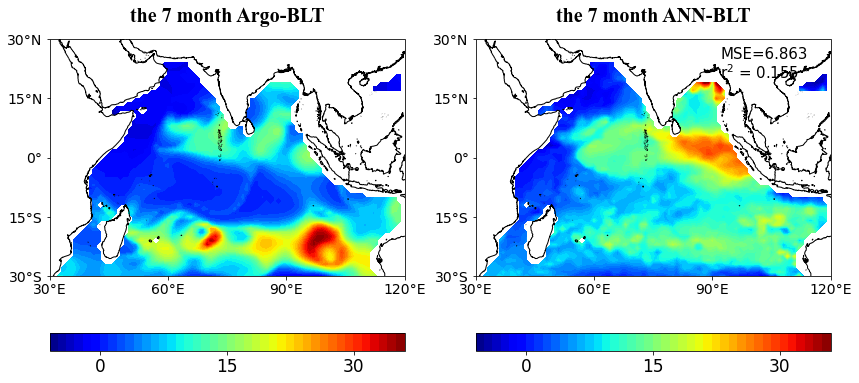

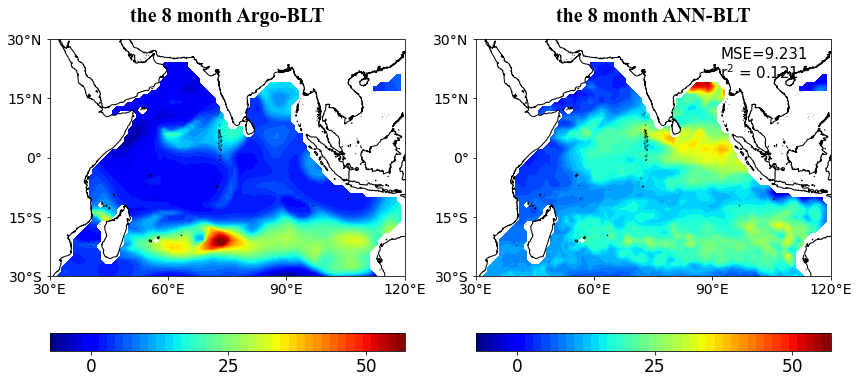

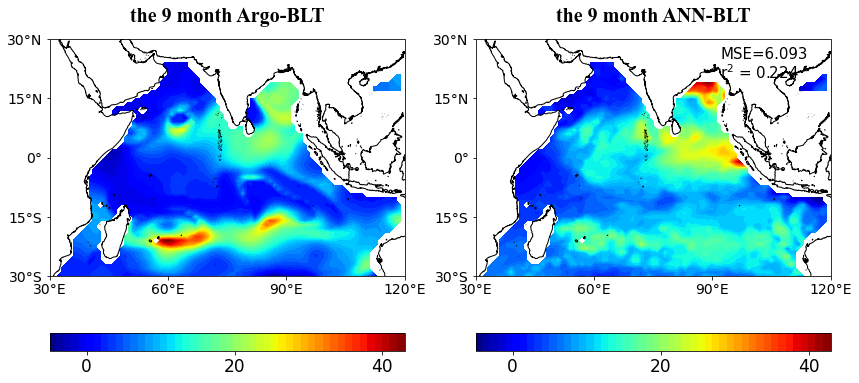

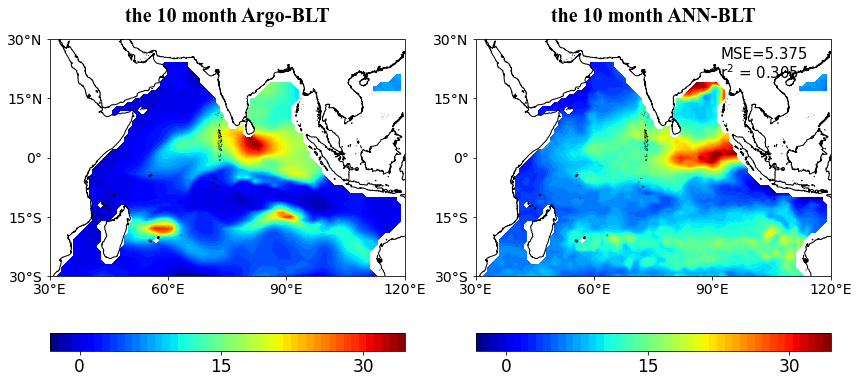

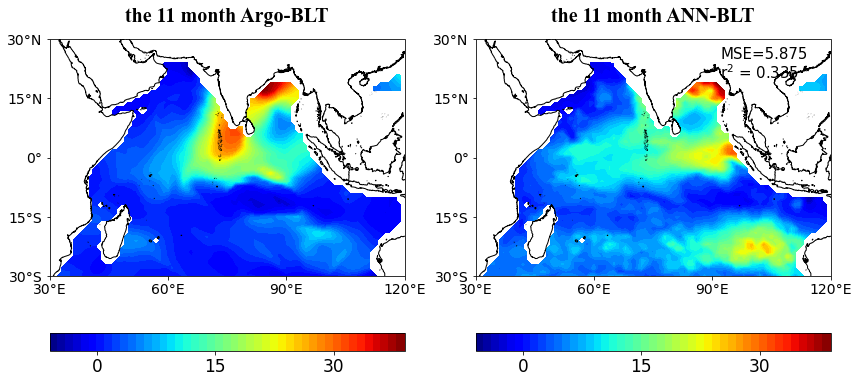

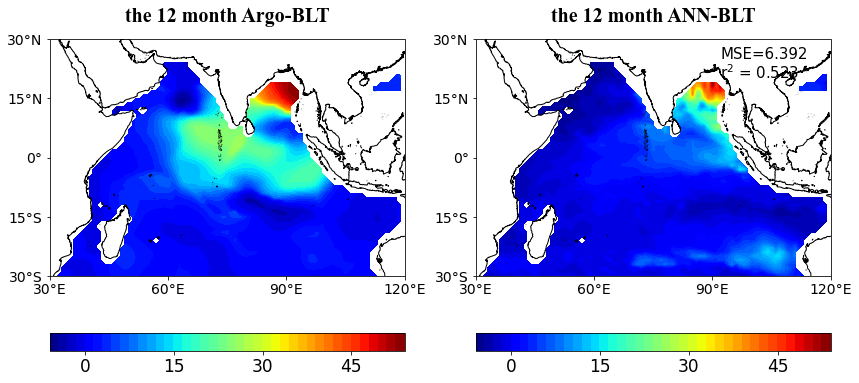

In [25]:
bar = [[0,15,30,45,60],[0,15,30,45,60],[0,10,20,30,40],[0,10,20,30,40],[0,10,20,30,40],[0,15,30,45,60],[0,15,30,45,60],[0,25,50,75,100],[0,20,40,60,80],[0,15,30,45,60],[0,15,30,45,60],[0,15,30,45,60]]
for j in range(12):
    lat = np.arange(-30,30)
    lon = np.arange(30,120)
    proj = ccrs.PlateCarree()
    fig = plt.figure(figsize=(14, 7))

    font2 = {'family' : 'Times New Roman',
    'weight' : 'bold',
    'size'   : 30,
    }

    
    ax1 =  fig.add_subplot(1, 2, 1, projection=proj)
    real = ax1.contourf(lon,lat,a[j+1,:,:],levels=50,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('jet'))
    ax1.coastlines("10m")
    plt.tick_params(labelsize=14)
    ax1.set_xticks([30,60,90,120], crs=ccrs.PlateCarree())
    ax1.set_yticks([-30,-15,0,15,30], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)
    plt.title('the '+ str(j+1) +' month Argo-BLT',font2,fontsize=20,y=1.05)
    cbar = plt.colorbar(real,extend='both',orientation='horizontal')
    cbar.ax.tick_params(labelsize=17)
    cbar.set_ticks(bar[j])
    plt.grid(linestyle='-.')

    ax2 =  fig.add_subplot(1, 2, 2, projection=proj)
    pre = ax2.contourf(lon,lat,b[j+1,:,:],levels=50,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('jet'))
    ax2.coastlines("10m")
    plt.tick_params(labelsize=14)
    ax2.set_xticks([30,60,90,120], crs=ccrs.PlateCarree())
    ax2.set_yticks([-30,-15,0,15,30], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
    plt.title('the '+ str(j+1) +' month ANN-BLT',font2, fontsize=20,y=1.05)
    cbar = plt.colorbar(real,extend='both',orientation='horizontal')
    cbar.ax.tick_params(labelsize=17)
    cbar.set_ticks(bar[j])
    plt.grid(linestyle='-.')
    plt.text(92,25,'MSE='+str(round(RMSE[j],3)),fontsize='15')
    plt.text(92,20,'r$^2$ = '+str(round(R2[j],3)),fontsize='15')
    plt.show()

月平均 RMSE : 2.409
月平均 R^2 : 0.742


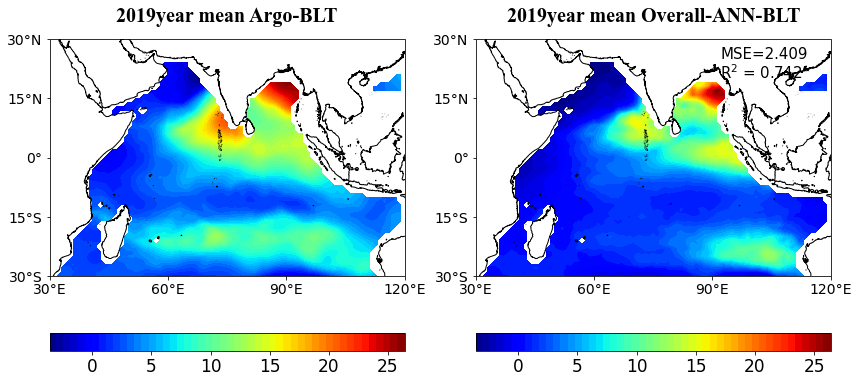

In [26]:
aa = np.nanmean(a[1:,:,:],axis=0).reshape(5400)
bb = np.nanmean(b[1:,:,:],axis=0).reshape(5400)
aa = pd.DataFrame(aa)
bb = pd.DataFrame(bb)
y = pd.concat([aa,bb], axis=1).dropna()
print('月平均 RMSE : %.3f' % (mean_squared_error(y.iloc[:,0].values,y.iloc[:,1].values) ** 0.5))
print('月平均 R^2 : %.3f' % (r2_score(y.iloc[:,0].values,y.iloc[:,1].values)))

lat = np.arange(-30,30)
lon = np.arange(30,120)
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(14, 7))

font2 = {'family' : 'Times New Roman',
'weight' : 'bold',
'size'   : 30,
}

ax1 =  fig.add_subplot(1, 2, 1, projection=proj)
real = ax1.contourf(lon,lat,np.nanmean(a[1:,:,:],axis=0),levels=50,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('jet'))
ax1.coastlines("10m")
plt.tick_params(labelsize=14)
ax1.set_xticks([30,60,90,120], crs=ccrs.PlateCarree())
ax1.set_yticks([-30,-15,0,15,30], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
plt.title('2019year mean Argo-BLT',font2,fontsize=20,y=1.05)
cbar = plt.colorbar(real,extend='both',orientation='horizontal')
cbar.ax.tick_params(labelsize=17)
cbar.set_ticks([0,5,10,15,20,25])
plt.grid(linestyle='-.')

ax2 =  fig.add_subplot(1, 2, 2, projection=proj)
pre = ax2.contourf(lon,lat,np.nanmean(b[1:,:,:],axis=0),levels=50,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('jet'))
ax2.coastlines("10m")
plt.tick_params(labelsize=14)
ax2.set_xticks([30,60,90,120], crs=ccrs.PlateCarree())
ax2.set_yticks([-30,-15,0,15,30], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
plt.title('2019year mean Overall-ANN-BLT',font2, fontsize=20,y=1.05)
cbar = plt.colorbar(real,extend='both',orientation='horizontal')
cbar.ax.tick_params(labelsize=17)
cbar.set_ticks([0,5,10,15,20,25])
plt.grid(linestyle='-.')
plt.text(92,25,'MSE='+str(round(mean_squared_error(y.iloc[:,0].values,y.iloc[:,1].values) ** 0.5,3)),fontsize='15')
plt.text(92,20,'R$^2$ = '+str(round(r2_score(y.iloc[:,0].values,y.iloc[:,1].values),3)),fontsize='15')
plt.show()

In [27]:
RMSE_zongti = RMSE
R2_zongti = R2

In [ ]:
ANN_loss = np.concatenate([np.array(RMSE_ANN).reshape(1,12),np.array(R2_ANN).reshape(1,12)],axis=0)
MRM_loss = np.concatenate([np.array(RMSE_MRM).reshape(1,12),np.array(R2_MRM).reshape(1,12)],axis=0)
ZONGTI_loss = np.concatenate([np.array(RMSE_zongti).reshape(1,12),np.array(R2_zongti).reshape(1,12)],axis=0)

In [29]:
from numpy import load
pso_ann_loss = load('pso_ann_loss.npy')

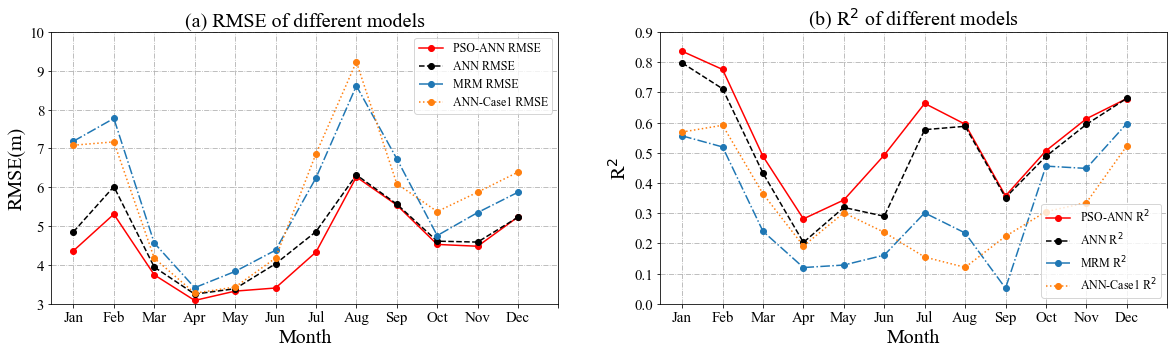

In [43]:
fig = plt.figure(figsize=(20,5))
font = {'family':'Times New Roman'}
font3 = {'family':'Times New Roman','size':12}
plt.subplot(1,2,1)
plt.plot(pso_ann_loss[0,:],label='PSO-ANN RMSE',marker='o',c='red',linestyle='-')
plt.plot(ANN_loss[0,:],label = 'ANN RMSE',marker='o',c='black',linestyle='--')
plt.plot(MRM_loss[0,:],label='MRM RMSE',marker='o',linestyle='-.')
plt.plot(ZONGTI_loss[0,:],label = 'ANN-Case1 RMSE',marker='o',linestyle=':')
plt.xlabel('Month',fontsize=20,fontdict=font)
plt.ylabel('RMSE(m)',fontsize=20,fontdict=font)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12],['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=15,
          fontproperties='Times New Roman')
plt.yticks(fontsize=15,fontproperties='Times New Roman')
plt.tick_params(labelsize=15)
plt.legend(prop=font3)
plt.grid(linestyle='-.')
plt.ylim(3,10)
plt.title("(a) RMSE of different models",fontsize=20,fontdict=font)

plt.subplot(1,2,2)
plt.plot(pso_ann_loss[1,:],label='PSO-ANN R$^2$',marker='o',c='red',linestyle='-')
plt.plot(ANN_loss[1,:],label = 'ANN R$^2$',marker='o',c='black',linestyle='--')
plt.plot(MRM_loss[1,:],label='MRM R$^2$',marker='o',linestyle='-.')
plt.plot(ZONGTI_loss[1,:],label = 'ANN-Case1 R$^2$',marker='o',linestyle=':')
plt.xlabel('Month',fontsize=20,fontdict=font)
plt.ylabel('R$^2$',fontsize=20,fontdict=font)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12],['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=15,
          fontproperties='Times New Roman')
plt.yticks(fontsize=15,fontproperties='Times New Roman')
plt.tick_params(labelsize=15)
plt.legend(prop=font3)
plt.grid(linestyle='-.')
plt.ylim(0,0.9)
plt.title("(b) R$^2$ of different models",fontsize=20,fontdict=font)
plt.savefig('图曲线.png')
plt.show()